# Regression  

**Goals:** In this notebook, we will analyze a large-scale dataset using simple linear, multiple linear, and polynomail/nonlinear regression.   

We will follow the datascience pipeline from data exploration/visualization to model development to performance evaluation

### Problem Statement  

You are a datascientist working for the World Health Organization. Passionate about human rights and equality, you decide to use your skills (and your access to WHO's data on global health statistics) for good. 
Specifically, you are looking to conduct health analysis to determine WHY some contries have lower life expectancies than others. Clearly, some factors such as status as a developed/developing nation have an obvious impact. But what about the volume of Polio cases, percentage spending on healthcare, schooling, or national population?

Your task is as follows:   
**Given health factors for 193 countries over the years 2000-2015, what predicting features contribute to lowered life expectencies? **

<img src="https://data.humdata.org/image/2018-12-20-114831.221148WH01.png" width="400">


## Setting Up  
We need to import our libraries... 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Import our specialized modules... 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

And read in our data.

In [ ]:
life_df = pd.read_csv('./LifeExpectancyData.csv')
life_df.head()

**Questions: **
   - In 1-2 sentences, describe what the dataset contains
   - What are 1-2 things that are unclear just from looking at the dataset? ex. What does Total expenditure mean?
   - Do you see anythign "wrong" with this data? Anything messy, unclear, incorrect, or misleading? 

We can perform a quick statistical analysis in one line

In [ ]:
life_df.describe()

Now we understand our features, but what about our target data?  
Life Expectancy is a continuous value output. However, is there a normal distribution. Use a distribution plot!



In [ ]:
sns.distplot(life_df['Life expectancy '].dropna(), color='teal')

### Question: What can be said about this data?   
Ex. What is the most common value? What can you say about the range of values? Is there a skew to this data? 

# Data Cleaning  
#### Question: The data isn't ready for processing just yet. What can you find wrong with this dataset?  
Hint: Look at names, titles, value types, etc.   

<img src="./resources/overwhelmed.png" width="150">

There are a few issues with this dataset that stand out right away. We will address a few here:      
- Look at the column names -- they look pretty messy  
- What about missing values? These are filled with nans  
- We are also given categorical (word) data which does not mesh with regression  

##  *Fun Fact:*  chaining methods in pandas makes code "Pandorable"  :)

In [ ]:
# print(life_df.columns)
life_df.columns = life_df.columns.str.strip().str.title()

#same as
# col_names = list(life_df.columns)
# new_names = []
# for col in list(col_names):
#     new_name = col.strip()
#     new_name = new_name.title()
#     new_names.append(new_name)
# life_df.columns = new_names


life_df.columns

<h5><center>Addressing Categorical Data</center></h5>      
Question: What is wrong with the status column contents for regression? ('Developing' or 'Developed')  
Question: How can we handle this? 


In [ ]:
life_df['Status'].unique()

In [ ]:
devel = life_df['Status']
new_cols = pd.get_dummies(devel)
new_cols.iloc[[3, 1000]]

In [ ]:
life_df['Developing'] = new_cols['Developing']
life_df.drop('Status', axis=1)
life_df.head(4)

<h5><center>Addressing Missing Values</center></h5>   
There are many ways to handle missing data. For example, you can drop rows with missing information. 
You could replace with the average value of htat feature. Or the value with the highest frequency. Or the max. Or the min. 

We will return to this later in the notebook, but know you have many options

In [ ]:
#count the number of nans in each columns
life_df.isnull().sum(axis = 0)

## Initial Investigation into Correlations: Scatter Plots and Correlation Heat Maps

We can get a sense of how our features relate to life expectancy really quickly.  
Let's visualize the correlation between each feature and life expectancy individually.

#### Question: What can we expect to learn form these plots? 

After looking at the results:  
Question: Which feature shows a strong positive correlation? Negative? None?  
Question: Which feature shows the strongest correlation? 

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15,20))
col_name_list= list(life_df.columns)
for i, ax in enumerate(axes.flatten()):
    if i == 23:
        break
    ax.scatter(life_df[col_name_list[i]], life_df['Life Expectancy'], color='purple')
    ax.set_title((col_name_list[i] +' vs Life Expectancy'))
fig.subplots_adjust(hspace=.5)

We can condense this data into one place using a **correlation plot**   
Returns coefficients from -1 to 1

## Questions: 
How do you interpret this plot?  
Can you tell which features would be most informative in our investigation?   
Is a feature with a correlation coeff of -1 useful?

In [ ]:
plt.figure(figsize = (14, 10))
sns.heatmap(life_df.corr(), annot = True)

## We have another issue!  
So much data -> big mess!! Every contry has multiple years tracked.   This can do more than just seem overwhelming:  
- This can cause the model to overfit due to overwhelming the model with detail. 
- Tracking year by year can "blur" the data by adding noise. 
    - For example, a specific GDP in 2000 will mean something much different than in 2015 due to inflation. Points in these years will thus shift, "blurring" the plot when compared side by side

But here, we will combine each year for the contries. Then we only have one entry for each.

In [ ]:
life_df = life_df.groupby('Country').mean()
life_df.drop('Year', axis=1, inplace=True)
life_df.head(3)

Now we will handle our missing values. For simplicity, we will replace each with the average value. 
#### Question: Do you have other ideas of replacements?

In [ ]:
life_df.fillna(value = life_df.mean(), inplace = True)
life_df.isnull().sum(axis = 0)

These visualizations are much cleaner. It is much easier to visually extract relationships through scatter plots. This also aids the correlation matrix


In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15,20))
col_name_list= list(life_df.columns)
for i, ax in enumerate(axes.flatten()):
    if i == 20:
        break
    ax.scatter(life_df[col_name_list[i]], life_df['Life Expectancy'], color='purple')
    ax.set_title((col_name_list[i] +' vs Life Expectancy'))
fig.subplots_adjust(hspace=.5)

In [ ]:
plt.figure(figsize = (14, 10))
sns.heatmap(life_df.corr(), annot = True)

## Scaling the Data

## Question: Why is scaling important? What does it mean to scale?
- For each value to be fairly compared. 
- GDP in 1000s. BMI around 20s

Guide for when to use minmax or standars scalar:  http://benalexkeen.com/feature-scaling-with-scikit-learn/
Summary: Standard scalar when data is normally distributed. Otherwise use minmax (but note succeptibility to outliers -- may investigate robust_scalar)

## Question:  
Why are we removing the life expectancy column before scaling?

In [ ]:
life_target = life_df['Life Expectancy']
life_features = life_df.drop('Life Expectancy', axis =1)
life_features.head(3)

In [ ]:
col_list = list(life_features.columns)

We use the minmaxscaler to scale our values.  
This returns a numpy matrix, but we can put the information back into a more manageable pandas dataframe. 

In [ ]:
min_max_scaler = MinMaxScaler()
life_features = min_max_scaler.fit_transform(life_features)

# col_list = list(life_features.columns)
feat_df = life_df.copy()
for i in col_list:
    feat_df[i]=min_max_scaler.fit_transform(feat_df[[i]])
    
print("make sure the features are scaled!")
print(life_features.max(), life_features.min())
feat_df.head(3)

## Question: Will this affect our correlation matrix?
Why not? 

In [ ]:
plt.figure(figsize = (14, 10))
sns.heatmap(feat_df.corr(), annot = True)

### Splitting our data into the training and test sets  

Our data can be broken up into features (input) and labels (expected output).   
We need to split our data into train and test sets. We will then train our model and test it's performance on a held-out test set.   
Therefore when we test it, we can test our model on data it hasn't seen before.  This indicates robustness/generalizability when deployed in the real world

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(life_features, life_target, train_size = 0.7, test_size = 0.3)

# Motivating Simple Linear Regression (One feature)  

Reminding us of our goal: What features best predict Life Expectancy and explains its variation given below? 
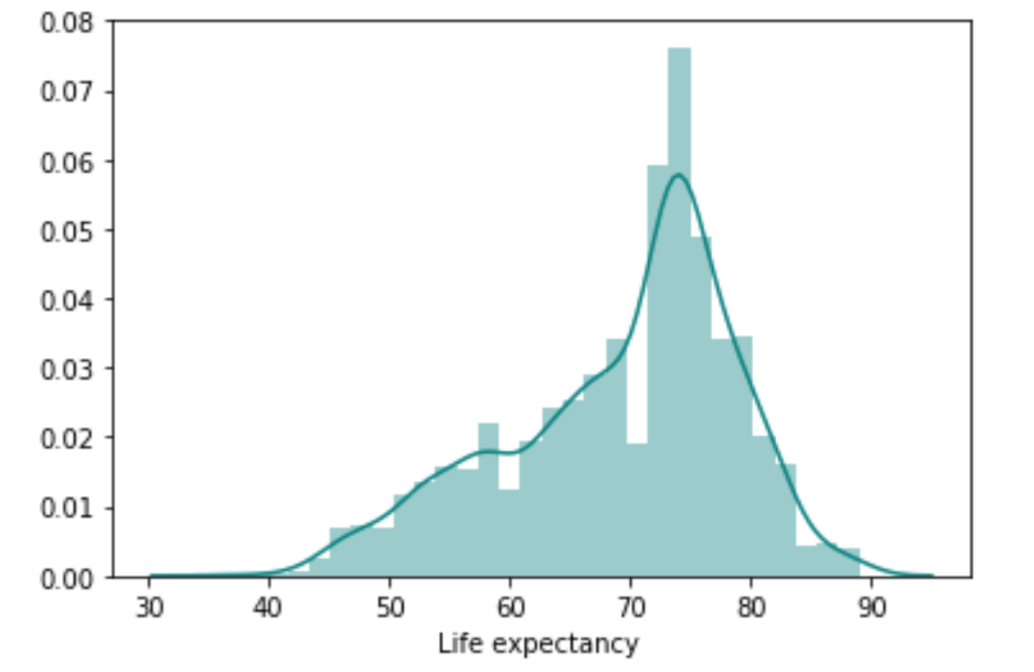

Remember that when looking at one feature, we get the equation y= mx + b  
Or: yhat = theta1 + theta2*x   
Let's see how Adult Mortality (which saw a strong correlation coefficient) explains life expectancy 
This may seem like kind of a "no duh" plot, but it shows a clear linear relation ideal for simple linear regression

In [ ]:
sns.regplot(x=feat_df['Adult Mortality'], y=feat_df['Life Expectancy'], data = feat_df, color='teal')

Let's look at BMI. 
Question: Is linear regression ideal for this feature? Why or why not?

In [ ]:
# feat_df
sns.regplot(x=feat_df['Bmi'], y=feat_df['Life Expectancy'], data = feat_df, color='teal')
#Can anybody tell what is wrong with using a linear model here?

In [ ]:
# Answer: BMI should not be linear. As you approach a healthy weight your expectancy should increase yes (startving)
# But after the point of morbid obesity, you should be lower. Maybe a quadratic fit would be best

# Making a Model
Now the fun part! Let's make a model and make our predictions!!

We create our linear regressor, train the model, and test it's accuracy on both the training and test sets

In [ ]:
adult_mort_feature = feat_df[['Adult Mortality']]
adult_mort_target = feat_df[['Life Expectancy']]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(adult_mort_feature, adult_mort_target, train_size = 0.7, test_size = 0.3)

linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)
print('R_square score on the training: %.2f' % linear_model.score(X_train, Y_train))

In [ ]:
linear_model_predict = linear_model.predict(X_test)
print('Coefficients: \n', linear_model.coef_)

mse_simple = round(mean_squared_error(Y_test, linear_model_predict), 2)
mae_simple = round(mean_absolute_error(Y_test, linear_model_predict), 2)
r2_simple = round(r2_score(Y_test, linear_model_predict), 2)
print("Mean squared error: ", mse_simple, "\nMean absolute error: ", mae_simple, '\nR_square score: ', r2_simple)

## Multiple Linear Regression   
<img src="./resources/multilin.png" width="300">
We can also look at multiple features at the same time 

Lets try all of the features

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(life_features, life_target, train_size = 0.7, test_size = 0.3)

linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)

print('R_square score on the training: %.2f' % linear_model.score(X_train, Y_train))

In [ ]:
linear_model_predict = linear_model.predict(X_test)

print('Coefficients: \n', linear_model.coef_)
mse_multi = round(mean_squared_error(Y_test, linear_model_predict), 2)
mae_multi = round(mean_absolute_error(Y_test, linear_model_predict), 2)
r2_multi = round(r2_score(Y_test, linear_model_predict), 2)
print("Mean squared error: ", mse_multi, "\nMean absolute error: ", mae_multi, '\nR_square score: ', r2_multi)

 Let's channel our inner goldilocks. Let's try a few features (not too few not too many)  
How can we choose? A good initial first step is to use those with the most significant correlations. 



In [ ]:
few_features = feat_df[['Adult Mortality', 'Schooling', 'Income Composition Of Resources']]
few_feature_targets = feat_df['Life Expectancy']

few_features.head()

X_train, X_test, Y_train, Y_test = train_test_split(few_features, few_feature_targets, random_state = 2,train_size = 0.7, test_size = 0.3)
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)
linear_model_predict = linear_model.predict(X_test)

In [ ]:
print('Coefficients: \n', linear_model.coef_)
mse_multi2 = round(mean_squared_error(Y_test, linear_model_predict), 2)
mae_multi2 = round(mean_absolute_error(Y_test, linear_model_predict), 2)
r2_multi2 = round(r2_score(Y_test, linear_model_predict), 2)
print("Mean squared error: ", mse_multi2, "\nMean absolute error: ", mae_multi2, '\nR_square score: ', r2_multi2)

Your goal might not be optimal accuracy. You can also use linear 
regression to understand the "importance" of each feature or its impact on the output. 
For example, I want to understand Hepatitis B, Measles, Diphtheria, Hiv/Aids, Polio
<img src="./resources/disease.png" width="200">


In [ ]:
disease_df = feat_df.copy()
disease_df = disease_df[['Life Expectancy', 'Hepatitis B', 'Measles', 'Diphtheria', 'Hiv/Aids', 'Polio']]
# disease_df.head()

In [ ]:
# life_features = min_max_scaler.fit_transform(life_features)
disease_feat = feat_df[['Hepatitis B', 'Measles', 'Diphtheria', 'Hiv/Aids', 'Polio']]
disease_target = feat_df['Life Expectancy']

X_train, X_test, Y_train, Y_test = train_test_split(disease_feat, disease_target, train_size = 0.7, test_size = 0.3)
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)
linear_model_predict = linear_model.predict(X_test)

In [ ]:
print('Coefficients: \n', linear_model.coef_)
mse_multi2 = round(mean_squared_error(Y_test, linear_model_predict), 2)
mae_multi2 = round(mean_absolute_error(Y_test, linear_model_predict), 2)
r2_multi2 = round(r2_score(Y_test, linear_model_predict), 2)
print("Mean squared error: ", mse_multi2, "\nMean absolute error: ", mae_multi2, '\nR_square score: ', r2_multi2)

Do you notice anything from the coefficients? Some are large and small.   
So measles has a lower impact than Diptheria negative!!!  
But countries that have many cases of polio have a higher life expectancy? Why? Because more reported?  
Becausea a disease in a rich country? 

## Nonlinear Regression.   

<img src="./resources/nonlin.png" width="400">

Some of these features have a nonlinear relationship with life expectancy (think of the BMI example).

We can fit a polynomial using polynomial regression. For example, we can find a cubic, quadratic, or generally nth order polynomial function.  

First we have to transform our data. Then we can fit our linear regression model and evaluate performance 

In [ ]:
quad_feature_transformer = PolynomialFeatures(2, interaction_only = True)

quad_feature_transformer.fit(X_train)
X_train_quad = quad_feature_transformer.transform(X_train)
X_test_quad = quad_feature_transformer.transform(X_test)

poly_model_quad = LinearRegression()
poly_model_quad.fit(X_train_quad, Y_train)
accuracy_score_quad = poly_model_quad.score(X_train_quad, Y_train)
poly_model_quad_predict = poly_model_quad.predict(X_test_quad)

print(accuracy_score_quad)

In [ ]:
mse_nonlin = round(mean_squared_error(Y_test, poly_model_quad_predict), 2)
mae_nonlin = round(mean_absolute_error(Y_test, poly_model_quad_predict), 2)
r2_nonlin = round(r2_score(Y_test, poly_model_quad_predict), 2)
print("Mean squared error: ", mse_nonlin, "\nMean absolute error: ", mae_nonlin, '\nR_square score: ', r2_nonlin)

We can also be more exciting with our model choices. Polynomials can be boring and also may not be the best. Other nonlinear functions can include a sigmoid function, gaussian curve, sin/cosine, inverse tangent, and more

### Building a report   

In [ ]:
report_dict = {'MSE': [mse_simple, mse_multi, mse_multi2, mse_nonlin], 
               'MAE': [mae_simple, mae_multi, mae_multi2, mae_nonlin], 
               'R^2' : [r2_simple, r2_multi, r2_multi2, r2_nonlin], 
               'Name': ['Simple', 'Multi1', 'Multi2', 'Nonlinear']}

report_df = pd.DataFrame(data=report_dict)
report_df.set_index('Name', inplace=True)
report_df

## Further Investigation  
- What are other techniques we could try?  
- How might we get even better accuracy?   
- What other things can you investigate using this dataset? 



## Conclusion  
In this notebook we covered:
- Reading in a dataset
- Exploring the data
- Preprocessing the data
- Visualizing the data
- Finding correlations visually with scatterplots 
- Finding correlations visually/numberically with correlation plots
- Fitting a simple linear regression model
- Fitting a multiple linear regression model
- Fitting polynomial models
- Fitting other non-linear models
- Analyzing model performance
- Using our model to make predictions